In [ ]:
!nvidia-smi

Wed Jan 19 11:16:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Init libraries

In [ ]:
!pip install transformers
!pip install wandb
!pip install datasets
!pip install trl

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,AutoModel, BertForSequenceClassification,AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import pandas as pd
import pickle
import os
from os import listdir
import shutil
import numpy as np
from datasets import load_metric

### Load data

In [ ]:
res_ref = pickle.load(open("/content/reference_exp_results#3.p", "rb"))

In [ ]:
res_ref["Input Data"][5]

'Nessus said, "All the seas seem to be of the same order of magnitude."'

#### Create encodings

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def preprocess_data(df):
  len_token = tokenizer(df["text"].to_list())["input_ids"]
  len_token_v = list(map(lambda x: len(x), len_token))
  df["len_token"] = len_token_v
  df = df[df.len_token <=30]
  df = df[df.len_token >=5]
  return df

df = preprocess_data(df_all)

all_sents = df["text"].to_list()
all_labels = df["label"].to_list()

# Splitting data -> adpat split if necessary
data_train, data_valtest, labels_train, labels_valtest = train_test_split(all_sents, all_labels, test_size=0.1, random_state = 42) 
data_val, data_test, labels_val, labels_test = train_test_split(data_valtest, labels_valtest, test_size=0.5,random_state = 42) 

assert len(all_sents) == len(data_test)+len(data_train)+len(data_val)

print(f'Number of training sentences: \t {len(data_train)}')
print(f'Number of validation sentences:  {len(data_val)}')
print(f'Number of test sentences: \t {len(data_test)}')

Number of training sentences: 	 67567
Number of validation sentences:  3754
Number of test sentences: 	 3754


In [ ]:
train_encodings = tokenizer(list(data_train),truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = "max_length",
                             max_length=max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
val_encodings = tokenizer(list(data_val), truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = "max_length",
                             max_length=max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
test_encodings = tokenizer(list(data_test), truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = "max_length",
                             max_length=max_len,
                             return_attention_mask=True,
                             return_tensors='pt')

In [ ]:
class Dataset_style(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = Dataset_style(train_encodings, labels_train)
val_dataset = Dataset_style(val_encodings, labels_val)
test_dataset = Dataset_style(test_encodings, labels_test)

### Train model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
_ = model.to(device)
model.train()

In [ ]:
#!wandb login
#import wandb
#wandb.init(name='scibert_run4_bs128_maxlen30_c_lr', project='gpt2-reward', entity="daniel_ml")
#wandb.watch(model, log='all')

In [ ]:
def load_roberta():
  !gdown --id 
  !gdown --id 

  os.mkdir("pretrained_roberta")
  shutil.move("/content/pytorch_model.bin", "/content/pretrained_roberta/pytorch_model.bin")
  shutil.move("/content/config.json", "/content/pretrained_roberta/config.json")


metric = load_metric("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis = -1)
  return metric.compute(predictions = predictions, references = labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=512,  # batch size per device during training
    per_device_eval_batch_size=512,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end= True,
    #report_to="wandb",
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics,           
)

trainer.train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print(f"Saving model at epoch")
model.save_pretrained('/content/drive/MyDrive/MRP2_model_checkpoints/GYAFC_RoBERTa')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving model at epoch


Configuration saved in /content/drive/MyDrive/MRP2_model_checkpoints/GYAFC_RoBERTa/config.json
Model weights saved in /content/drive/MyDrive/MRP2_model_checkpoints/GYAFC_RoBERTa/pytorch_model.bin


In [ ]:
wandb.finish()

### Inference

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from scipy.special import softmax
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from trl.core import build_bert_batch_from_txt

In [ ]:
# predict labels and create pandas df for overview
def pred_df(data,labels, encoded_dataset = None):
  if not encoded_dataset:
    encodings = tokenizer(list(data), padding=True)
    encoded_dataset = Dataset_style(encodings, list(labels))
  pred = trainer.predict(encoded_dataset)
  res = softmax(pred[0], axis = 1)
  df = pd.DataFrame.from_records(res, columns = ["prob_non_sci", "prob_sci"])
  df["sent"] = list(data)
  df['pred_label'] = np.where((df.prob_non_sci > df.prob_sci),0,1)
  df["true_label"] = list(labels)
  df = df[["sent", "true_label", "pred_label", "prob_non_sci","prob_sci"]]
  return df

# This provides just a way to illustrate our confusion matrices in a nice and labeled way
def show_confusion_matrix(confusion_matrix, names = ['Scientific', 'Non-Scientifc'], save_path = None):
  confusion_df = pd.DataFrame(cm, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  if save_path:
    plt.savefig(save_path)
  plt.show()

In [ ]:
df2 = pred_df(data_train, labels_train, train_dataset)

***** Running Prediction *****
  Num examples = 199521
  Batch size = 512
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


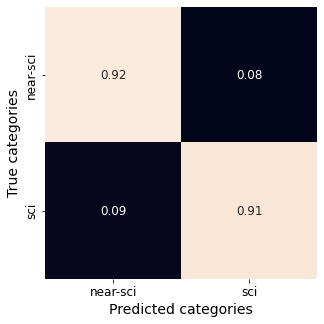

In [ ]:
cm = confusion_matrix(df2.true_label, df2.pred_label, normalize = 'true')
show_confusion_matrix(cm, names = ['near-sci', 'sci'], save_path=None)

# Inference function

In [ ]:
model.forward(**tokenizer(text, return_tensors="pt"))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
 sentiment_inputs, attention_masks = build_bert_batch_from_txt([text,text], tokenizer, device)

In [ ]:
game_data = {"query": ["this is t1 in the query", "this is t2 in the query"], "response": ["this is t1 in the response", "this is t2 in the response"]}

In [ ]:
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timing = dict()

config = {
    "lm_name": "lvwerra/gpt2-imdb",
    "ref_lm_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "tk_name": "gpt2",
    "steps": 25600,
    "batch_size": 2,
    "forward_batch_size": 1,
    "ppo_epochs": 4,   
    "txt_in_len": 5,
    "txt_out_len": 15,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
}
fbs = config['forward_batch_size']



#### tokenize text for sentiment analysis
t = time.time()
texts = [q + r for q,r in zip(game_data['query'], game_data['response'])]
print(texts)
sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, tokenizer, device)    
timing['time/build_input_sentiment'] = time.time()-t
attention_masks.to(device)

#### get sentiment score
t = time.time()
rewards = []
for i in range(int(config['batch_size']/fbs)):
    res = model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs])[0].detach()
    print(res)
    rewards.append(res)
rewards = torch.cat(rewards)
timing['time/get_sentiment_preds'] = time.time()-t

In [ ]:
batch_size_gpt = 2
fbs = 2
softmax = nn.Softmax(dim=1)

def forward_bert(query_text, response_text, tokenizer, model):
  combined_text = query_text + response_text
  model_inputs, attention_masks = build_bert_batch_from_txt(combined_text, tokenizer, device)
  rewards = []
  for i in range(int(batch_size_gpt*2/fbs)):
    res = model.forward(model_inputs[i*fbs:(i+1)*fbs],attention_masks[i*fbs:(i+1)*fbs])[0].detach()
    res = softmax(res)[:, 0]
    rewards.append(res)
  rewards = torch.cat(rewards)
  query_softmax, response_softmax = torch.split(rewards, len(response_text))
  rewards = response_softmax -query_softmax
  return rewards

In [ ]:
import pandas as pd

df =  pd.DataFrame({"text": all_sents, "label": all_labels})
# Informal text -> output
game_data["response"] = [df[df.label == 0].text.iloc[0],df[df.label == 0].text.iloc[1]]
# Formal text -> Input
game_data["query"] = [df[df.label == 1].text.iloc[0], df[df.label == 1].text.iloc[1]]

In [ ]:
r = forward_bert(game_data["query"],game_data["response"], tokenizer, model)